<a href="https://colab.research.google.com/github/hcarrusca/diabetic_patient_trend/blob/main/Residence_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Patient at Risk of Readmission Analysis

In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from imblearn.over_sampling import SMOTE


In [99]:
# Load the CSV
df = pd.read_csv('diabetic_data.csv')

# Preview data
print("Shape:", df.shape)
df.head()

Shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Data Cleaning
Identifying Missing Values

In [100]:
# Count of missing or unknown values
df.replace('?', pd.NA, inplace=True)
df.replace('Unknown/Invalid', pd.NA, inplace=True)
df.replace(' ', pd.NA, inplace=True)

missing_values = df.isna().sum()
missing_values[missing_values > 0]


,0
race,2273
gender,3
weight,98569
payer_code,40256
medical_specialty,49949
diag_1,21
diag_2,358
diag_3,1423
max_glu_serum,96420
A1Cresult,84748


In [101]:
# Drop columns with too many unknowns
df_cleaned = df.drop(columns=['weight', 'payer_code', 'medical_specialty','max_glu_serum','A1Cresult'], errors='ignore')

df_cleaned.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [102]:
# Dropping the rows with missing values on the 'race' field

df_cleaned = df_cleaned.dropna(subset=['race'])
df_cleaned.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [103]:
df_cleaned.shape

(99493, 45)

# Exploring the Clean Dataset
Checking data types and unique values

In [104]:
# Check data types for each column
df_cleaned.dtypes

for col in df_cleaned.columns:
   print(f"{col}:{df_cleaned[col].dtype}")



encounter_id:int64
patient_nbr:int64
race:object
gender:object
age:object
admission_type_id:int64
discharge_disposition_id:int64
admission_source_id:int64
time_in_hospital:int64
num_lab_procedures:int64
num_procedures:int64
num_medications:int64
number_outpatient:int64
number_emergency:int64
number_inpatient:int64
diag_1:object
diag_2:object
diag_3:object
number_diagnoses:int64
metformin:object
repaglinide:object
nateglinide:object
chlorpropamide:object
glimepiride:object
acetohexamide:object
glipizide:object
glyburide:object
tolbutamide:object
pioglitazone:object
rosiglitazone:object
acarbose:object
miglitol:object
troglitazone:object
tolazamide:object
examide:object
citoglipton:object
insulin:object
glyburide-metformin:object
glipizide-metformin:object
glimepiride-pioglitazone:object
metformin-rosiglitazone:object
metformin-pioglitazone:object
change:object
diabetesMed:object
readmitted:object


In [105]:
cat_cols = df_cleaned.select_dtypes(include='object').columns

for col in cat_cols:
    print(f"\nUnique values in '{col}':")
    print(df_cleaned[col].unique())


Unique values in 'race':
['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']

Unique values in 'gender':
['Female' 'Male' <NA>]

Unique values in 'age':
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']

Unique values in 'diag_1':
['250.83' '276' '648' '8' '197' '414' '428' '398' '434' '250.7' '157'
 '518' '999' '410' '682' '402' 'V57' '189' '786' '427' '996' '277' '584'
 '462' '473' '411' '174' '486' '998' '511' '432' '626' '295' '196' '250.6'
 '182' '845' '423' '808' '250.4' '722' '403' '250.11' '784' '707' '440'
 '151' '715' '997' '198' '564' '38' '590' '578' '250.32' '433' '569' '185'
 '536' '255' '250.13' '599' '558' '574' '491' '560' '244' '250.03' '577'
 '730' '188' '824' '250.8' '332' '562' '291' '296' '510' '401' '263' '438'
 '70' '250.02' '493' '642' '571' '738' '593' '618' '250.42' '807' '456'
 '446' '572' '575' '250.41' '820' '515' '780' '250.22' '995' '235'
 '250.82' '721' '787' '556' '162' '724' '282' '514' 'V55

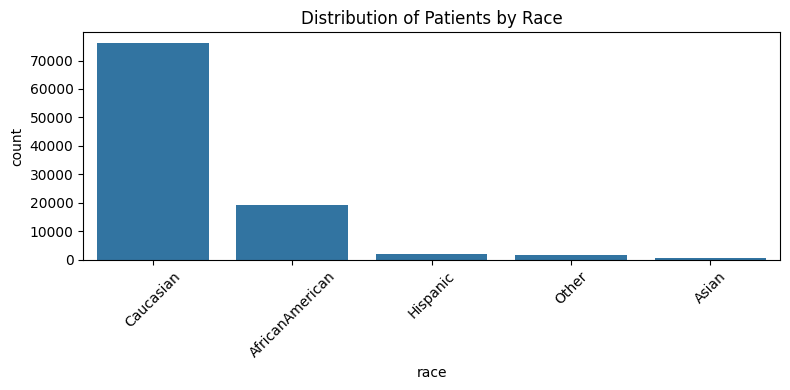

In [106]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_cleaned, x='race', order=df_cleaned['race'].value_counts().index)
plt.title('Distribution of Patients by Race')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

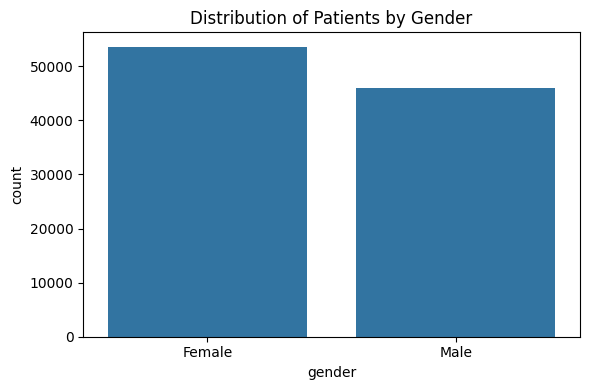

In [107]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_cleaned, x='gender', order=df_cleaned['gender'].value_counts().index)
plt.title('Distribution of Patients by Gender')
plt.tight_layout()
plt.show()

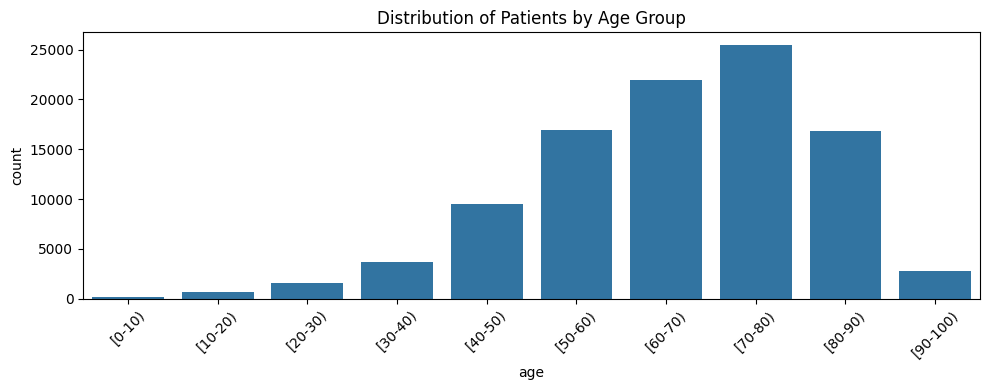

In [108]:
plt.figure(figsize=(10, 4))
age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
             '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
sns.countplot(data=df_cleaned, x='age', order=age_order)
plt.title('Distribution of Patients by Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

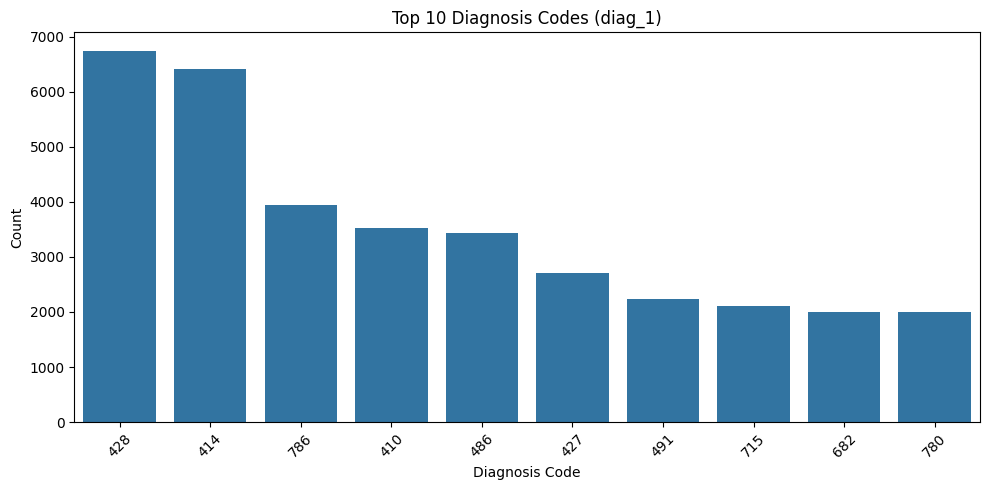

In [109]:
# 4. Top 10 most common diag_1 codes
plt.figure(figsize=(10, 5))
top_diag1 = df_cleaned['diag_1'].value_counts().head(10)
sns.barplot(x=top_diag1.index, y=top_diag1.values)
plt.title('Top 10 Diagnosis Codes (diag_1)')
plt.xlabel('Diagnosis Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

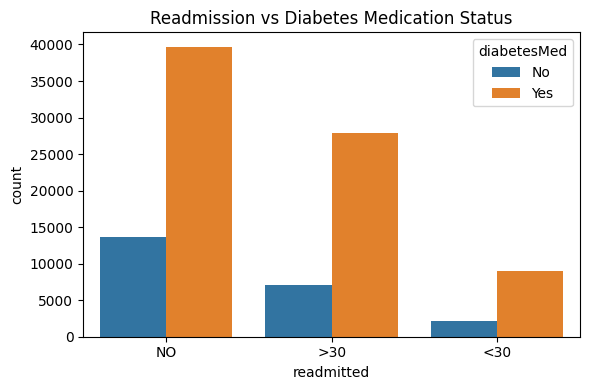

In [110]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_cleaned, x='readmitted', hue='diabetesMed')
plt.title('Readmission vs Diabetes Medication Status')
plt.tight_layout()
plt.show()

In [111]:
# Relative frequency table (row-wise)
readmission_rel_freq = pd.crosstab(
    df_cleaned['diabetesMed'],
    df_cleaned['readmitted'],
    normalize='index'  # normalizes each row (i.e., per diabetesMed group)
)

# Optional: format as percentages
readmission_rel_freq_percent = (readmission_rel_freq * 100).round(2)

# Display table
display(Markdown("### Relative Frequency of Readmission per Diabetes Medication Status"))
display(readmission_rel_freq_percent)

### Relative Frequency of Readmission per Diabetes Medication Status

readmitted,<30,>30,NO
diabetesMed,,,
No,9.64,31.07,59.28
Yes,11.70,36.42,51.88


Text(0.5, 1.0, 'Readmission by Gender')

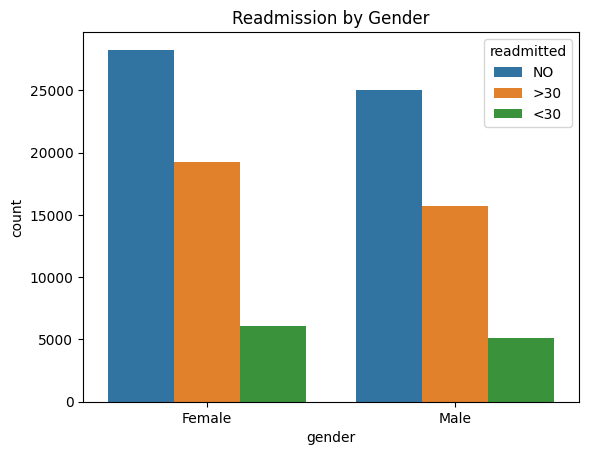

In [112]:
sns.countplot(data=df_cleaned, x='gender', hue='readmitted')
plt.title("Readmission by Gender")

Text(0.5, 1.0, 'Readmission by Race')

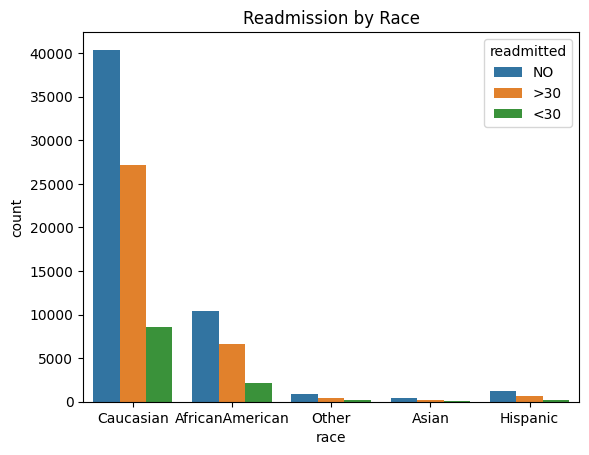

In [113]:
sns.countplot(data=df_cleaned, x='race', hue='readmitted')
plt.title("Readmission by Race")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '[0-10)'),
  Text(1, 0, '[10-20)'),
  Text(2, 0, '[20-30)'),
  Text(3, 0, '[30-40)'),
  Text(4, 0, '[40-50)'),
  Text(5, 0, '[50-60)'),
  Text(6, 0, '[60-70)'),
  Text(7, 0, '[70-80)'),
  Text(8, 0, '[80-90)'),
  Text(9, 0, '[90-100)')])

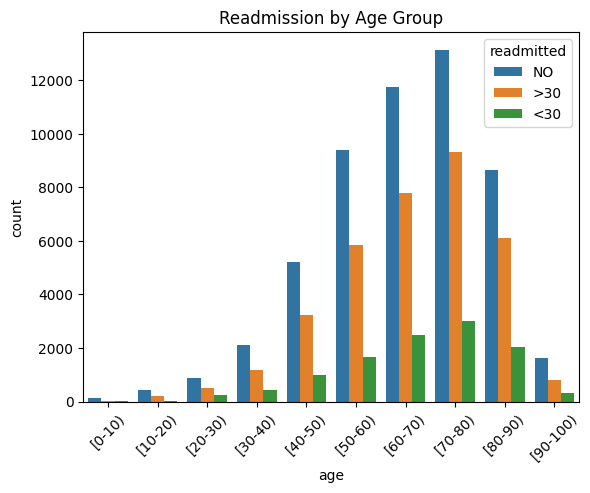

In [114]:
age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
             '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
sns.countplot(data=df_cleaned, x='age', hue='readmitted', order=age_order)
plt.title("Readmission by Age Group")
plt.xticks(rotation=45)

# Encoding Nominal Variables
Encoding Categorical and Ordinal Variables

In [115]:
## Encoding Variables

# Binary or ordinal
df_cleaned['gender'] = df_cleaned['gender'].astype(str)
df_cleaned['gender'] = LabelEncoder().fit_transform(df_cleaned['gender'])

df_cleaned['readmitted'] = df_cleaned['readmitted'].map({'NO': 0, '>30': 0, '<30': 1})
df_cleaned['diabetesMed'] = df_cleaned['diabetesMed'].map({'No': 0, 'Yes': 1})
df_cleaned['change'] = df_cleaned['change'].map({'No': 0, 'Ch': 1})

# Ordinal: age group
age_order = {'[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4,
             '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9}
df_cleaned['age'] = df_cleaned['age'].map(age_order)

In [116]:
## One-hot encoding Race

df_cleaned = pd.get_dummies(df_cleaned, columns=['race'], drop_first=True)

In [117]:
## Encoding medical columns as ordinal variables

med_columns = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
    'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone'
]

med_mapping = {'No': 0, 'Down': 1, 'Steady': 2, 'Up': 3}

for col in med_columns:
    df_cleaned[col] = df_cleaned[col].map(med_mapping)


In [118]:
## Categorizing Diagnosis before encoding

for col in ['diag_1', 'diag_2', 'diag_3']:
    df_cleaned[col] = df_cleaned[col].astype(str).str[:3]

def categorize_diag(code):
    try:
        code = float(code)
        if code == 250:
            return 'Diabetes'
        elif 390 <= code <= 459 or code == 785:
            return 'Circulatory'
        elif 460 <= code <= 519 or code == 786:
            return 'Respiratory'
        elif 520 <= code <= 579 or code == 787:
            return 'Digestive'
        elif 800 <= code <= 999:
            return 'Injury'
        elif 290 <= code <= 319:
            return 'Mental Health'
        else:
            return 'Other'
    except:
        return 'Unknown'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df_cleaned[col] = df_cleaned[col].map(categorize_diag)

In [119]:
## One-hot Encoding Diagnosis Variables

df_cleaned = pd.get_dummies(df_cleaned, columns=['diag_1', 'diag_2', 'diag_3'], drop_first=True)

In [120]:
df_cleaned.head()

,encounter_id,patient_nbr,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,diag_2_Other,diag_2_Respiratory,diag_2_Unknown,diag_3_Diabetes,diag_3_Digestive,diag_3_Injury,diag_3_Mental Health,diag_3_Other,diag_3_Respiratory,diag_3_Unknown
0,2278392,8222157,1,0,6,25,1,1,41,0,...,False,False,True,False,False,False,False,False,False,True
1,149190,55629189,1,1,1,1,7,3,59,0,...,False,False,False,False,False,False,False,True,False,False
2,64410,86047875,1,2,1,1,7,2,11,5,...,False,False,False,False,False,False,False,False,False,True
3,500364,82442376,2,3,1,1,7,2,44,1,...,False,False,False,False,False,False,False,False,False,False
4,16680,42519267,2,4,1,1,7,1,51,0,...,True,False,False,True,False,False,False,False,False,False


In [121]:
for col in df_cleaned.columns:
    print(f"Column: {col}")
    print(f"  Data type      : {df_cleaned[col].dtype}")
    print(f"  Unique values  : {df_cleaned[col].nunique()}")
    print("-" * 40)

Column: encounter_id
  Data type      : int64
  Unique values  : 99493
----------------------------------------
Column: patient_nbr
  Data type      : int64
  Unique values  : 69668
----------------------------------------
Column: gender
  Data type      : int64
  Unique values  : 3
----------------------------------------
Column: age
  Data type      : int64
  Unique values  : 10
----------------------------------------
Column: admission_type_id
  Data type      : int64
  Unique values  : 8
----------------------------------------
Column: discharge_disposition_id
  Data type      : int64
  Unique values  : 26
----------------------------------------
Column: admission_source_id
  Data type      : int64
  Unique values  : 17
----------------------------------------
Column: time_in_hospital
  Data type      : int64
  Unique values  : 14
----------------------------------------
Column: num_lab_procedures
  Data type      : int64
  Unique values  : 118
-------------------------------------

In [122]:
# Checking data in independent variable
print(df_cleaned['readmitted'].value_counts())

readmitted
0    88324
1    11169
Name: count, dtype: int64


# PCA Attempt
Upon analysis, we identified that PCA is not the best approach for categorical variables

In [123]:
## Executing PCA to reduce dimensionality

features = df_cleaned.drop(columns=['readmitted'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

NameError: name 'StandardScaler' is not defined

In [ ]:
# Initialize PCA (keep enough components to explain 95% of the variance)
pca = PCA(n_components=0.80)  # or choose a fixed number like n_components=10
X_pca = pca.fit_transform(X_scaled)


In [ ]:
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)


In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

print("Explained variance by each component:")
print(explained_variance)

print("\nCumulative explained variance:")
print(cumulative_variance)


# Model Building - Logistic Regression
## Iteration 1 - Logistic Regression
Building a predictive model using Logistic Regression

In [133]:
# identifying dependent (y) and independent variables (x)

X = df_cleaned.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'])
y = df_cleaned['readmitted']


In [134]:
# establishing train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [159]:
# fitting Logistic Regression model using liblinear optimization

model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

In [160]:
# Evaluating Classification through confusion matrix

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))


Confusion Matrix:
 [[17631    34]
 [ 2205    29]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     17665
           1       0.46      0.01      0.03      2234

    accuracy                           0.89     19899
   macro avg       0.67      0.51      0.48     19899
weighted avg       0.84      0.89      0.84     19899


ROC AUC Score: 0.6402203447682562


In [161]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    # Predict probabilities and adjust threshold
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row-wise % (per actual class)

    # ROC AUC
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    # Print metrics
    print("="*50)
    print("🔍 Model Evaluation Report")
    print("="*50)
    print(f"✔️ Threshold: {threshold}")
    print(f"✔️ ROC AUC Score: {auc:.4f}")
    print("\n📋 Classification Report:\n")
    print(report)

    # Plot normalized confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized * 100, annot=True, fmt='.1f', cmap='YlGnBu',
                xticklabels=['Predicted: No', 'Predicted: Yes'],
                yticklabels=['Actual: No', 'Actual: Yes'])
    plt.title('📉 Confusion Matrix (% of Actual Class)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

🔍 Model Evaluation Report
✔️ Threshold: 0.5
✔️ ROC AUC Score: 0.6402

📋 Classification Report:

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17665
           1       0.46      0.01      0.03      2234

    accuracy                           0.89     19899
   macro avg       0.67      0.51      0.48     19899
weighted avg       0.84      0.89      0.84     19899



<ipython-input-161-1627929492>:31: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


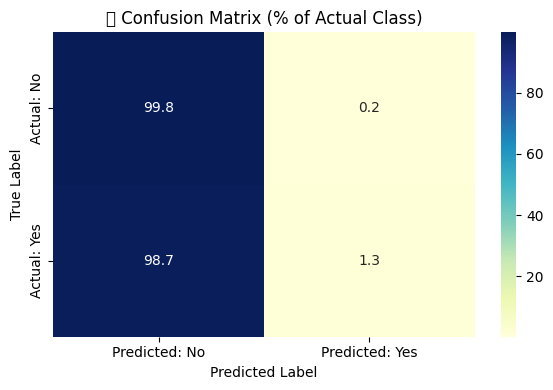

In [162]:
evaluate_model(model, X_test, y_test, threshold=0.5)

## Iteration 2 - Adjusting Class Weights


In [163]:
model = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [164]:
# Evaluating Classification after adjusting class weights

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[12036  5629]
 [ 1090  1144]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.68      0.78     17665
           1       0.17      0.51      0.25      2234

    accuracy                           0.66     19899
   macro avg       0.54      0.60      0.52     19899
weighted avg       0.83      0.66      0.72     19899


ROC AUC Score: 0.6414007233499418


🔍 Model Evaluation Report
✔️ Threshold: 0.5
✔️ ROC AUC Score: 0.6414

📋 Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.68      0.78     17665
           1       0.17      0.51      0.25      2234

    accuracy                           0.66     19899
   macro avg       0.54      0.60      0.52     19899
weighted avg       0.83      0.66      0.72     19899



<ipython-input-161-1627929492>:31: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


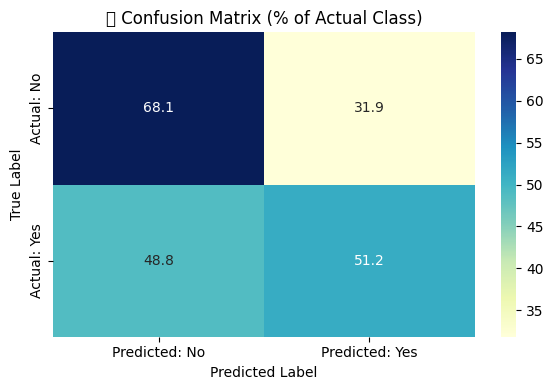

In [165]:
evaluate_model(model, X_test, y_test, threshold=0.5)

## Iteration 3 - Oversampling using SMOTE


In [166]:
# Apply SMOTE to the training set
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

In [167]:
# Fitting the logistic regression
# No need to balance class weights, as it is already done through SMOTE

model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, solver='liblinear')

In [168]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

[[14467  3198]
 [ 1766   468]]
              precision    recall  f1-score   support

           0       0.89      0.82      0.85     17665
           1       0.13      0.21      0.16      2234

    accuracy                           0.75     19899
   macro avg       0.51      0.51      0.51     19899
weighted avg       0.81      0.75      0.78     19899

ROC AUC Score: 0.5355945642073798


🔍 Model Evaluation Report
✔️ Threshold: 0.5
✔️ ROC AUC Score: 0.5356

📋 Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.82      0.85     17665
           1       0.13      0.21      0.16      2234

    accuracy                           0.75     19899
   macro avg       0.51      0.51      0.51     19899
weighted avg       0.81      0.75      0.78     19899



<ipython-input-161-1627929492>:31: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


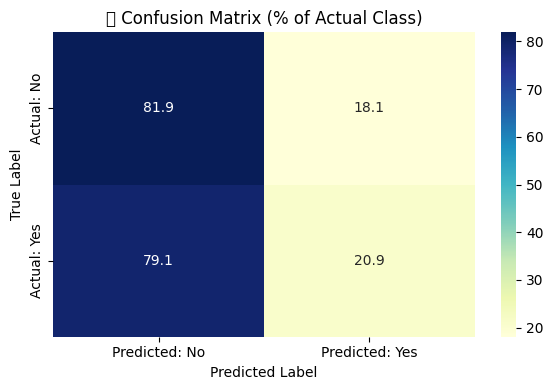

In [169]:
evaluate_model(model, X_test, y_test, threshold=0.5)

# Data Model - Sub-tables

In [174]:
# Patient table

patient_table = df[['patient_nbr', 'gender', 'age', 'race']].drop_duplicates()
patient_table.head()

,patient_nbr,gender,age,race
0,8222157,Female,[0-10),Caucasian
1,55629189,Female,[10-20),Caucasian
2,86047875,Female,[20-30),AfricanAmerican
3,82442376,Male,[30-40),Caucasian
4,42519267,Male,[40-50),Caucasian


In [182]:
# Encounter table

encounter_columns = [
    'encounter_id', 'patient_nbr', 'time_in_hospital','readmitted', 'number_diagnoses',
    'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient',
    'change', 'diabetesMed','admission_type_id', 'discharge_disposition_id',
    'admission_source_id'
]
encounter_table = df[encounter_columns]

encounter_table.head()


,encounter_id,patient_nbr,time_in_hospital,readmitted,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,change,diabetesMed,admission_type_id,discharge_disposition_id,admission_source_id
0,2278392,8222157,1,NO,1,41,0,1,0,0,0,No,No,6,25,1
1,149190,55629189,3,>30,9,59,0,18,0,0,0,Ch,Yes,1,1,7
2,64410,86047875,2,NO,6,11,5,13,2,0,1,No,Yes,1,1,7
3,500364,82442376,2,NO,7,44,1,16,0,0,0,Ch,Yes,1,1,7
4,16680,42519267,1,NO,5,51,0,8,0,0,0,Ch,Yes,1,1,7


In [179]:
# diagnosis table

diag_columns = [col for col in df.columns if col.startswith('diag_')]
diagnosis_table = df[['encounter_id'] + diag_columns]

diagnosis_table.head()

,encounter_id,diag_1,diag_2,diag_3
0,2278392,250.83,<NA>,<NA>
1,149190,276,250.01,255
2,64410,648,250,V27
3,500364,8,250.43,403
4,16680,197,157,250


In [181]:
med_cols = [
    col for col in df.columns
    if col in [
        'metformin','insulin','glipizide','glyburide','pioglitazone','rosiglitazone',
        'nateglinide','glimepiride','chlorpropamide','acarbose','miglitol','tolazamide',
        'troglitazone','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',
        'metformin-rosiglitazone','metformin-pioglitazone','acetohexamide','tolbutamide',
        'examide','citoglipton','repaglinide'
    ]
]
medication_table = df[['encounter_id'] + med_cols]

medication_table.head()


,encounter_id,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,...,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone
0,2278392,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
1,149190,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Up,No,No,No,No,No
2,64410,No,No,No,No,No,No,Steady,No,No,...,No,No,No,No,No,No,No,No,No,No
3,500364,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Up,No,No,No,No,No
4,16680,No,No,No,No,No,No,Steady,No,No,...,No,No,No,No,Steady,No,No,No,No,No
